# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-coz2tp6o
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-coz2tp6o
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
    

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

## Load Model

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# tests

In [6]:
example_prompt = "House was sold in one. Ice was sold in two. Fire was sold in three. Ear was sold in four. Ocean was sold in"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' sold', ' in', ' one', '.', ' Ice', ' was', ' sold', ' in', ' two', '.', ' Fire', ' was', ' sold', ' in', ' three', '.', ' Ear', ' was', ' sold', ' in', ' four', '.', ' Ocean', ' was', ' sold', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 20.24 Prob: 53.76% Token: | five|

Top 0th token. Logit: 20.24 Prob: 53.76% Token: | five|
Top 1th token. Logit: 19.19 Prob: 18.78% Token: | six|
Top 2th token. Logit: 18.58 Prob: 10.16% Token: | seven|
Top 3th token. Logit: 17.47 Prob:  3.36% Token: | eight|
Top 4th token. Logit: 17.38 Prob:  3.08% Token: | four|
Top 5th token. Logit: 17.06 Prob:  2.24% Token: | ten|
Top 6th token. Logit: 16.65 Prob:  1.48% Token: | three|
Top 7th token. Logit: 16.44 Prob:  1.19% Token: | nine|
Top 8th token. Logit: 16.34 Prob:  1.08% Token: | one|
Top 9th token. Logit: 15.92 Prob:  0.71% Token: | two|


Ranks of the answer tokens: [(' five', 0)]

In [7]:
example_prompt = "House was sold in one. Ice was sold in two. Fire was sold in three. Ear was sold in"
example_answer = " four"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' was', ' sold', ' in', ' one', '.', ' Ice', ' was', ' sold', ' in', ' two', '.', ' Fire', ' was', ' sold', ' in', ' three', '.', ' Ear', ' was', ' sold', ' in']
Tokenized answer: [' four']


Performance on answer token:
Rank: 0        Logit: 20.30 Prob: 70.24% Token: | four|

Top 0th token. Logit: 20.30 Prob: 70.24% Token: | four|
Top 1th token. Logit: 18.07 Prob:  7.55% Token: | five|
Top 2th token. Logit: 17.98 Prob:  6.90% Token: | six|
Top 3th token. Logit: 17.27 Prob:  3.36% Token: | three|
Top 4th token. Logit: 17.03 Prob:  2.66% Token: | one|
Top 5th token. Logit: 16.98 Prob:  2.52% Token: | two|
Top 6th token. Logit: 16.56 Prob:  1.66% Token: | eight|
Top 7th token. Logit: 15.98 Prob:  0.93% Token: | seven|
Top 8th token. Logit: 15.10 Prob:  0.38% Token: | ten|
Top 9th token. Logit: 14.99 Prob:  0.34% Token: | nine|


Ranks of the answer tokens: [(' four', 0)]

In [8]:
len(model.tokenizer.tokenize(example_prompt))

22

In [9]:
example_prompt = "House sold in one. Ice sold in two. Fire sold in three. Ear sold in"
example_answer = " four"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' one', '.', ' Ice', ' sold', ' in', ' two', '.', ' Fire', ' sold', ' in', ' three', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' four']


Performance on answer token:
Rank: 0        Logit: 20.11 Prob: 70.09% Token: | four|

Top 0th token. Logit: 20.11 Prob: 70.09% Token: | four|
Top 1th token. Logit: 17.95 Prob:  8.12% Token: | five|
Top 2th token. Logit: 17.88 Prob:  7.57% Token: | six|
Top 3th token. Logit: 16.61 Prob:  2.11% Token: | three|
Top 4th token. Logit: 16.56 Prob:  2.01% Token: | eight|
Top 5th token. Logit: 16.55 Prob:  1.99% Token: | one|
Top 6th token. Logit: 16.36 Prob:  1.65% Token: | two|
Top 7th token. Logit: 15.81 Prob:  0.95% Token: | seven|
Top 8th token. Logit: 15.12 Prob:  0.48% Token: | ten|
Top 9th token. Logit: 14.69 Prob:  0.31% Token: | nine|


Ranks of the answer tokens: [(' four', 0)]

In [10]:
len(model.tokenizer.tokenize(example_prompt))

18

In [11]:
example_prompt = "House sold in six. Ice sold in seven. Fire sold in eight. Ear sold in"
example_answer = " nine"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' six', '.', ' Ice', ' sold', ' in', ' seven', '.', ' Fire', ' sold', ' in', ' eight', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' nine']


Performance on answer token:
Rank: 0        Logit: 19.67 Prob: 38.25% Token: | nine|

Top 0th token. Logit: 19.67 Prob: 38.25% Token: | nine|
Top 1th token. Logit: 18.62 Prob: 13.44% Token: | ten|
Top 2th token. Logit: 17.80 Prob:  5.92% Token: | eight|
Top 3th token. Logit: 17.61 Prob:  4.90% Token: | twelve|
Top 4th token. Logit: 17.31 Prob:  3.63% Token: | five|
Top 5th token. Logit: 17.21 Prob:  3.27% Token: | seven|
Top 6th token. Logit: 17.08 Prob:  2.87% Token: | eleven|
Top 7th token. Logit: 17.03 Prob:  2.73% Token: | twenty|
Top 8th token. Logit: 16.94 Prob:  2.52% Token: | thirteen|
Top 9th token. Logit: 16.79 Prob:  2.16% Token: | six|


Ranks of the answer tokens: [(' nine', 0)]

In [12]:
example_prompt = "House sold in nine. Ice sold in ten. Fire sold in eleven. Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' nine', '.', ' Ice', ' sold', ' in', ' ten', '.', ' Fire', ' sold', ' in', ' eleven', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 3        Logit: 18.73 Prob:  9.04% Token: | twelve|

Top 0th token. Logit: 19.25 Prob: 15.29% Token: | ten|
Top 1th token. Logit: 18.86 Prob: 10.36% Token: | eight|
Top 2th token. Logit: 18.73 Prob:  9.06% Token: | six|
Top 3th token. Logit: 18.73 Prob:  9.04% Token: | twelve|
Top 4th token. Logit: 18.61 Prob:  8.03% Token: | nine|
Top 5th token. Logit: 18.60 Prob:  7.94% Token: | five|
Top 6th token. Logit: 18.40 Prob:  6.55% Token: | four|
Top 7th token. Logit: 18.35 Prob:  6.20% Token: | seven|
Top 8th token. Logit: 18.03 Prob:  4.50% Token: | eleven|
Top 9th token. Logit: 17.57 Prob:  2.84% Token: | fourteen|


Ranks of the answer tokens: [(' twelve', 3)]

In [13]:
example_prompt = "Bob sold in eight. House sold in nine. Ice sold in ten. Fire sold in eleven. Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' in', ' eight', '.', ' House', ' sold', ' in', ' nine', '.', ' Ice', ' sold', ' in', ' ten', '.', ' Fire', ' sold', ' in', ' eleven', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 19.23 Prob: 22.23% Token: | twelve|

Top 0th token. Logit: 19.23 Prob: 22.23% Token: | twelve|
Top 1th token. Logit: 18.36 Prob:  9.30% Token: | ten|
Top 2th token. Logit: 18.19 Prob:  7.86% Token: | thirteen|
Top 3th token. Logit: 18.03 Prob:  6.68% Token: | fourteen|
Top 4th token. Logit: 17.94 Prob:  6.11% Token: | eleven|
Top 5th token. Logit: 17.83 Prob:  5.50% Token: | fifteen|
Top 6th token. Logit: 17.74 Prob:  4.99% Token: | twenty|
Top 7th token. Logit: 17.65 Prob:  4.60% Token: | eight|
Top 8th token. Logit: 17.62 Prob:  4.45% Token: | six|
Top 9th token. Logit: 17.48 Prob:  3.85% Token: | nine|


Ranks of the answer tokens: [(' twelve', 0)]

In [14]:
example_prompt = "Bob sold in eight House sold in nine Ice sold in ten Fire sold in eleven Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' in', ' eight', ' House', ' sold', ' in', ' nine', ' Ice', ' sold', ' in', ' ten', ' Fire', ' sold', ' in', ' eleven', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 18.04 Prob: 26.00% Token: | twelve|

Top 0th token. Logit: 18.04 Prob: 26.00% Token: | twelve|
Top 1th token. Logit: 17.20 Prob: 11.19% Token: | thirteen|
Top 2th token. Logit: 17.09 Prob: 10.04% Token: | fourteen|
Top 3th token. Logit: 16.92 Prob:  8.49% Token: | eleven|
Top 4th token. Logit: 16.56 Prob:  5.91% Token: | fifteen|
Top 5th token. Logit: 16.51 Prob:  5.64% Token: | ten|
Top 6th token. Logit: 16.24 Prob:  4.28% Token: | sixteen|
Top 7th token. Logit: 16.04 Prob:  3.51% Token: | twenty|
Top 8th token. Logit: 15.88 Prob:  2.99% Token: | six|
Top 9th token. Logit: 15.74 Prob:  2.60% Token: | nine|


Ranks of the answer tokens: [(' twelve', 0)]

In [15]:
example_prompt = "Bob sold eight House sold nine Ice sold ten Fire sold eleven Ear sold"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' eight', ' House', ' sold', ' nine', ' Ice', ' sold', ' ten', ' Fire', ' sold', ' eleven', ' Ear', ' sold']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 17.16 Prob: 26.70% Token: | twelve|

Top 0th token. Logit: 17.16 Prob: 26.70% Token: | twelve|
Top 1th token. Logit: 16.44 Prob: 13.06% Token: | eleven|
Top 2th token. Logit: 16.31 Prob: 11.43% Token: | thirteen|
Top 3th token. Logit: 15.85 Prob:  7.21% Token: | ten|
Top 4th token. Logit: 15.61 Prob:  5.68% Token: | fourteen|
Top 5th token. Logit: 15.45 Prob:  4.86% Token: | fifteen|
Top 6th token. Logit: 15.30 Prob:  4.18% Token: | twenty|
Top 7th token. Logit: 15.07 Prob:  3.31% Token: | sixteen|
Top 8th token. Logit: 14.86 Prob:  2.68% Token: | six|
Top 9th token. Logit: 14.62 Prob:  2.11% Token: | nine|


Ranks of the answer tokens: [(' twelve', 0)]

In [16]:
example_prompt = "Bob sold eight House sold nine Ice sold ten Fire sold eleven Ear sold"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' eight', ' House', ' sold', ' nine', ' Ice', ' sold', ' ten', ' Fire', ' sold', ' eleven', ' Ear', ' sold']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 17.16 Prob: 26.70% Token: | twelve|

Top 0th token. Logit: 17.16 Prob: 26.70% Token: | twelve|
Top 1th token. Logit: 16.44 Prob: 13.06% Token: | eleven|
Top 2th token. Logit: 16.31 Prob: 11.43% Token: | thirteen|
Top 3th token. Logit: 15.85 Prob:  7.21% Token: | ten|
Top 4th token. Logit: 15.61 Prob:  5.68% Token: | fourteen|
Top 5th token. Logit: 15.45 Prob:  4.86% Token: | fifteen|
Top 6th token. Logit: 15.30 Prob:  4.18% Token: | twenty|
Top 7th token. Logit: 15.07 Prob:  3.31% Token: | sixteen|
Top 8th token. Logit: 14.86 Prob:  2.68% Token: | six|
Top 9th token. Logit: 14.62 Prob:  2.11% Token: | nine|


Ranks of the answer tokens: [(' twelve', 0)]

In [17]:
example_prompt = "Bob sold August House sold September Ice sold October Fire sold November Ear sold"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' August', ' House', ' sold', ' September', ' Ice', ' sold', ' October', ' Fire', ' sold', ' November', ' Ear', ' sold']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 217      Logit:  7.92 Prob:  0.00% Token: | twelve|

Top 0th token. Logit: 18.78 Prob: 92.03% Token: | December|
Top 1th token. Logit: 15.09 Prob:  2.31% Token: | February|
Top 2th token. Logit: 14.25 Prob:  1.00% Token: | November|
Top 3th token. Logit: 13.68 Prob:  0.57% Token: | Dec|
Top 4th token. Logit: 13.41 Prob:  0.43% Token: | January|
Top 5th token. Logit: 13.14 Prob:  0.33% Token: | June|
Top 6th token. Logit: 13.12 Prob:  0.32% Token: |December|
Top 7th token. Logit: 12.87 Prob:  0.25% Token: | April|
Top 8th token. Logit: 12.43 Prob:  0.16% Token: | March|
Top 9th token. Logit: 12.38 Prob:  0.15% Token: | May|


Ranks of the answer tokens: [(' twelve', 217)]

In [18]:
example_prompt = "Bob sold six House sold seven Ice sold eight Fire sold nine Ear sold"
example_answer = " ten"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Bob', ' sold', ' six', ' House', ' sold', ' seven', ' Ice', ' sold', ' eight', ' Fire', ' sold', ' nine', ' Ear', ' sold']
Tokenized answer: [' ten']


Performance on answer token:
Rank: 1        Logit: 16.25 Prob: 12.61% Token: | ten|

Top 0th token. Logit: 16.70 Prob: 19.75% Token: | nine|
Top 1th token. Logit: 16.25 Prob: 12.61% Token: | ten|
Top 2th token. Logit: 15.94 Prob:  9.24% Token: | seven|
Top 3th token. Logit: 15.72 Prob:  7.41% Token: | eight|
Top 4th token. Logit: 15.58 Prob:  6.44% Token: | six|
Top 5th token. Logit: 15.45 Prob:  5.66% Token: | twelve|
Top 6th token. Logit: 15.43 Prob:  5.53% Token: | five|
Top 7th token. Logit: 15.11 Prob:  4.01% Token: | four|
Top 8th token. Logit: 15.04 Prob:  3.74% Token: | eleven|
Top 9th token. Logit: 14.84 Prob:  3.06% Token: | thirteen|


Ranks of the answer tokens: [(' ten', 1)]

In [19]:
example_prompt = "Jar sold one House sold two Ice sold three Fire sold four Ear sold"
example_answer = " five"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Jar', ' sold', ' one', ' House', ' sold', ' two', ' Ice', ' sold', ' three', ' Fire', ' sold', ' four', ' Ear', ' sold']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 15.02 Prob: 18.27% Token: | five|

Top 0th token. Logit: 15.02 Prob: 18.27% Token: | five|
Top 1th token. Logit: 14.79 Prob: 14.57% Token: | four|
Top 2th token. Logit: 14.62 Prob: 12.32% Token: | three|
Top 3th token. Logit: 14.40 Prob:  9.83% Token: | one|
Top 4th token. Logit: 14.26 Prob:  8.55% Token: | two|
Top 5th token. Logit: 14.14 Prob:  7.57% Token: | six|
Top 6th token. Logit: 13.54 Prob:  4.18% Token: | seven|
Top 7th token. Logit: 12.82 Prob:  2.02% Token: | eight|
Top 8th token. Logit: 12.36 Prob:  1.29% Token: | ten|
Top 9th token. Logit: 12.18 Prob:  1.07% Token: | a|


Ranks of the answer tokens: [(' five', 0)]

In [20]:
len(model.tokenizer.tokenize(example_prompt))

14

In [21]:
example_prompt = 'Austin born January Mary born February Frank born March Jessica born April Kent born'
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Austin', ' born', ' January', ' Mary', ' born', ' February', ' Frank', ' born', ' March', ' Jessica', ' born', ' April', ' Kent', ' born']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.97 Prob: 33.28% Token: | May|

Top 0th token. Logit: 20.97 Prob: 33.28% Token: | May|
Top 1th token. Logit: 20.69 Prob: 25.28% Token: | June|
Top 2th token. Logit: 20.04 Prob: 13.23% Token: | April|
Top 3th token. Logit: 19.29 Prob:  6.21% Token: | July|
Top 4th token. Logit: 19.13 Prob:  5.30% Token: | November|
Top 5th token. Logit: 18.64 Prob:  3.26% Token: | August|
Top 6th token. Logit: 18.40 Prob:  2.55% Token: | March|
Top 7th token. Logit: 18.37 Prob:  2.49% Token: | December|
Top 8th token. Logit: 18.19 Prob:  2.06% Token: | September|
Top 9th token. Logit: 18.16 Prob:  2.02% Token: | October|


Ranks of the answer tokens: [(' May', 0)]

In [22]:
len(model.tokenizer.tokenize(example_prompt))

14

In [23]:
example_prompt = 'Austin likes January Mary likes February Frank likes March Jessica likes April Kent likes'
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Austin', ' likes', ' January', ' Mary', ' likes', ' February', ' Frank', ' likes', ' March', ' Jessica', ' likes', ' April', ' Kent', ' likes']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.99 Prob: 95.20% Token: | May|

Top 0th token. Logit: 20.99 Prob: 95.20% Token: | May|
Top 1th token. Logit: 17.69 Prob:  3.53% Token: | April|
Top 2th token. Logit: 14.92 Prob:  0.22% Token: | June|
Top 3th token. Logit: 14.88 Prob:  0.21% Token: | March|
Top 4th token. Logit: 14.30 Prob:  0.12% Token: | July|
Top 5th token. Logit: 13.42 Prob:  0.05% Token: | 5|
Top 6th token. Logit: 13.29 Prob:  0.04% Token: | November|
Top 7th token. Logit: 13.14 Prob:  0.04% Token: |May|
Top 8th token. Logit: 12.59 Prob:  0.02% Token: | fifth|
Top 9th token. Logit: 12.40 Prob:  0.02% Token: | Mar|


Ranks of the answer tokens: [(' May', 0)]

In [24]:
example_prompt = 'House in January Lamp in February Fridge in March Chair in April Desk in'
example_answer = " May"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' in', ' January', ' Lamp', ' in', ' February', ' Fr', 'idge', ' in', ' March', ' Chair', ' in', ' April', ' Desk', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 22.16 Prob: 90.35% Token: | May|

Top 0th token. Logit: 22.16 Prob: 90.35% Token: | May|
Top 1th token. Logit: 19.41 Prob:  5.73% Token: | June|
Top 2th token. Logit: 17.83 Prob:  1.19% Token: | July|
Top 3th token. Logit: 17.48 Prob:  0.83% Token: | April|
Top 4th token. Logit: 16.72 Prob:  0.39% Token: | November|
Top 5th token. Logit: 16.66 Prob:  0.37% Token: | September|
Top 6th token. Logit: 16.27 Prob:  0.25% Token: | March|
Top 7th token. Logit: 15.80 Prob:  0.16% Token: | October|
Top 8th token. Logit: 15.52 Prob:  0.12% Token: | August|
Top 9th token. Logit: 14.97 Prob:  0.07% Token: | December|


Ranks of the answer tokens: [(' May', 0)]

In [25]:
example_prompt = 'House in two Lamp in three Ham in four Chair in five Desk in'
example_answer = " six"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' in', ' two', ' Lamp', ' in', ' three', ' Ham', ' in', ' four', ' Chair', ' in', ' five', ' Desk', ' in']
Tokenized answer: [' six']


Performance on answer token:
Rank: 0        Logit: 17.40 Prob: 27.20% Token: | six|

Top 0th token. Logit: 17.40 Prob: 27.20% Token: | six|
Top 1th token. Logit: 16.80 Prob: 14.90% Token: | ten|
Top 2th token. Logit: 16.77 Prob: 14.48% Token: | seven|
Top 3th token. Logit: 16.32 Prob:  9.24% Token: | five|
Top 4th token. Logit: 15.85 Prob:  5.79% Token: | eight|
Top 5th token. Logit: 15.77 Prob:  5.32% Token: | four|
Top 6th token. Logit: 15.19 Prob:  2.97% Token: | one|
Top 7th token. Logit: 15.04 Prob:  2.57% Token: | nine|
Top 8th token. Logit: 14.95 Prob:  2.35% Token: | three|
Top 9th token. Logit: 14.90 Prob:  2.23% Token: | two|


Ranks of the answer tokens: [(' six', 0)]

In [26]:
example_prompt = 'House in two Lamp in three Ham in four Chair in five Desk in'
example_answer = " six"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' in', ' two', ' Lamp', ' in', ' three', ' Ham', ' in', ' four', ' Chair', ' in', ' five', ' Desk', ' in']
Tokenized answer: [' six']


Performance on answer token:
Rank: 0        Logit: 17.40 Prob: 27.20% Token: | six|

Top 0th token. Logit: 17.40 Prob: 27.20% Token: | six|
Top 1th token. Logit: 16.80 Prob: 14.90% Token: | ten|
Top 2th token. Logit: 16.77 Prob: 14.48% Token: | seven|
Top 3th token. Logit: 16.32 Prob:  9.24% Token: | five|
Top 4th token. Logit: 15.85 Prob:  5.79% Token: | eight|
Top 5th token. Logit: 15.77 Prob:  5.32% Token: | four|
Top 6th token. Logit: 15.19 Prob:  2.97% Token: | one|
Top 7th token. Logit: 15.04 Prob:  2.57% Token: | nine|
Top 8th token. Logit: 14.95 Prob:  2.35% Token: | three|
Top 9th token. Logit: 14.90 Prob:  2.23% Token: | two|


Ranks of the answer tokens: [(' six', 0)]

In [27]:
model.tokenizer.tokenize(example_prompt)

['House',
 'Ġin',
 'Ġtwo',
 'ĠLamp',
 'Ġin',
 'Ġthree',
 'ĠHam',
 'Ġin',
 'Ġfour',
 'ĠChair',
 'Ġin',
 'Ġfive',
 'ĠDesk',
 'Ġin']

In [28]:
example_prompt = "House sold in one. Ice sold in two. Fire sold in three. Ear sold in"
example_answer = " four"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' one', '.', ' Ice', ' sold', ' in', ' two', '.', ' Fire', ' sold', ' in', ' three', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' four']


Performance on answer token:
Rank: 0        Logit: 20.11 Prob: 70.09% Token: | four|

Top 0th token. Logit: 20.11 Prob: 70.09% Token: | four|
Top 1th token. Logit: 17.95 Prob:  8.12% Token: | five|
Top 2th token. Logit: 17.88 Prob:  7.57% Token: | six|
Top 3th token. Logit: 16.61 Prob:  2.11% Token: | three|
Top 4th token. Logit: 16.56 Prob:  2.01% Token: | eight|
Top 5th token. Logit: 16.55 Prob:  1.99% Token: | one|
Top 6th token. Logit: 16.36 Prob:  1.65% Token: | two|
Top 7th token. Logit: 15.81 Prob:  0.95% Token: | seven|
Top 8th token. Logit: 15.12 Prob:  0.48% Token: | ten|
Top 9th token. Logit: 14.69 Prob:  0.31% Token: | nine|


Ranks of the answer tokens: [(' four', 0)]

In [29]:
example_prompt = "House sold in one Ice sold in two Fire sold in three Ear sold in"
example_answer = " four"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' one', ' Ice', ' sold', ' in', ' two', ' Fire', ' sold', ' in', ' three', ' Ear', ' sold', ' in']
Tokenized answer: [' four']


Performance on answer token:
Rank: 0        Logit: 18.05 Prob: 43.43% Token: | four|

Top 0th token. Logit: 18.05 Prob: 43.43% Token: | four|
Top 1th token. Logit: 16.58 Prob:  9.99% Token: | one|
Top 2th token. Logit: 16.55 Prob:  9.74% Token: | three|
Top 3th token. Logit: 16.52 Prob:  9.39% Token: | five|
Top 4th token. Logit: 16.20 Prob:  6.85% Token: | two|
Top 5th token. Logit: 16.07 Prob:  6.04% Token: | six|
Top 6th token. Logit: 15.21 Prob:  2.53% Token: | eight|
Top 7th token. Logit: 14.74 Prob:  1.59% Token: | seven|
Top 8th token. Logit: 13.98 Prob:  0.74% Token: | ten|
Top 9th token. Logit: 13.91 Prob:  0.70% Token: | nine|


Ranks of the answer tokens: [(' four', 0)]

In [30]:
example_prompt = "House sold in nine Ice sold in ten Fire sold in eleven Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'House', ' sold', ' in', ' nine', ' Ice', ' sold', ' in', ' ten', ' Fire', ' sold', ' in', ' eleven', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 1        Logit: 18.09 Prob: 11.82% Token: | twelve|

Top 0th token. Logit: 18.19 Prob: 13.15% Token: | ten|
Top 1th token. Logit: 18.09 Prob: 11.82% Token: | twelve|
Top 2th token. Logit: 17.88 Prob:  9.65% Token: | nine|
Top 3th token. Logit: 17.78 Prob:  8.70% Token: | eight|
Top 4th token. Logit: 17.70 Prob:  8.07% Token: | six|
Top 5th token. Logit: 17.62 Prob:  7.40% Token: | eleven|
Top 6th token. Logit: 17.43 Prob:  6.10% Token: | seven|
Top 7th token. Logit: 17.15 Prob:  4.63% Token: | five|
Top 8th token. Logit: 17.07 Prob:  4.30% Token: | thirteen|
Top 9th token. Logit: 17.07 Prob:  4.27% Token: | fourteen|


Ranks of the answer tokens: [(' twelve', 1)]

In [31]:
example_prompt = "Desk sold in eight House sold in nine Ice sold in ten Fire sold in eleven Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Desk', ' sold', ' in', ' eight', ' House', ' sold', ' in', ' nine', ' Ice', ' sold', ' in', ' ten', ' Fire', ' sold', ' in', ' eleven', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 18.15 Prob: 24.05% Token: | twelve|

Top 0th token. Logit: 18.15 Prob: 24.05% Token: | twelve|
Top 1th token. Logit: 17.34 Prob: 10.71% Token: | thirteen|
Top 2th token. Logit: 17.23 Prob:  9.62% Token: | fourteen|
Top 3th token. Logit: 17.03 Prob:  7.85% Token: | eleven|
Top 4th token. Logit: 16.69 Prob:  5.58% Token: | fifteen|
Top 5th token. Logit: 16.68 Prob:  5.54% Token: | ten|
Top 6th token. Logit: 16.45 Prob:  4.39% Token: | sixteen|
Top 7th token. Logit: 16.27 Prob:  3.68% Token: | six|
Top 8th token. Logit: 16.26 Prob:  3.63% Token: | twenty|
Top 9th token. Logit: 16.09 Prob:  3.07% Token: | nine|


Ranks of the answer tokens: [(' twelve', 0)]

In [32]:
example_prompt = "Desk sold in eight. House sold in nine. Ice sold in ten. Fire sold in eleven. Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Desk', ' sold', ' in', ' eight', '.', ' House', ' sold', ' in', ' nine', '.', ' Ice', ' sold', ' in', ' ten', '.', ' Fire', ' sold', ' in', ' eleven', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 19.09 Prob: 24.97% Token: | twelve|

Top 0th token. Logit: 19.09 Prob: 24.97% Token: | twelve|
Top 1th token. Logit: 18.09 Prob:  9.15% Token: | thirteen|
Top 2th token. Logit: 17.90 Prob:  7.56% Token: | ten|
Top 3th token. Logit: 17.89 Prob:  7.46% Token: | fourteen|
Top 4th token. Logit: 17.71 Prob:  6.28% Token: | fifteen|
Top 5th token. Logit: 17.68 Prob:  6.06% Token: | eleven|
Top 6th token. Logit: 17.44 Prob:  4.79% Token: | twenty|
Top 7th token. Logit: 17.21 Prob:  3.80% Token: | six|
Top 8th token. Logit: 17.19 Prob:  3.74% Token: | eight|
Top 9th token. Logit: 17.13 Prob:  3.51% Token: | sixteen|


Ranks of the answer tokens: [(' twelve', 0)]

In [33]:
example_prompt = "Desk was sold in eight. House was sold in nine. Ice was sold in ten. Fire was sold in eleven. Ear sold in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Desk', ' was', ' sold', ' in', ' eight', '.', ' House', ' was', ' sold', ' in', ' nine', '.', ' Ice', ' was', ' sold', ' in', ' ten', '.', ' Fire', ' was', ' sold', ' in', ' eleven', '.', ' Ear', ' sold', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 19.06 Prob: 20.14% Token: | twelve|

Top 0th token. Logit: 19.06 Prob: 20.14% Token: | twelve|
Top 1th token. Logit: 18.38 Prob: 10.21% Token: | ten|
Top 2th token. Logit: 17.98 Prob:  6.81% Token: | eight|
Top 3th token. Logit: 17.90 Prob:  6.28% Token: | six|
Top 4th token. Logit: 17.88 Prob:  6.19% Token: | thirteen|
Top 5th token. Logit: 17.83 Prob:  5.89% Token: | eleven|
Top 6th token. Logit: 17.77 Prob:  5.54% Token: | four|
Top 7th token. Logit: 17.72 Prob:  5.26% Token: | fourteen|
Top 8th token. Logit: 17.58 Prob:  4.59% Token: | five|
Top 9th token. Logit: 17.55 Prob:  4.47% Token: | fifteen|


Ranks of the answer tokens: [(' twelve', 0)]

In [34]:
example_prompt = "Desk in eight House in nine Ice in ten Fire in eleven Ear in"
example_answer = " twelve"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Desk', ' in', ' eight', ' House', ' in', ' nine', ' Ice', ' in', ' ten', ' Fire', ' in', ' eleven', ' Ear', ' in']
Tokenized answer: [' twelve']


Performance on answer token:
Rank: 0        Logit: 17.02 Prob: 21.76% Token: | twelve|

Top 0th token. Logit: 17.02 Prob: 21.76% Token: | twelve|
Top 1th token. Logit: 16.68 Prob: 15.47% Token: | ten|
Top 2th token. Logit: 16.62 Prob: 14.63% Token: | eleven|
Top 3th token. Logit: 15.68 Prob:  5.70% Token: | thirteen|
Top 4th token. Logit: 15.63 Prob:  5.43% Token: | nine|
Top 5th token. Logit: 15.48 Prob:  4.68% Token: | fourteen|
Top 6th token. Logit: 15.42 Prob:  4.39% Token: | six|
Top 7th token. Logit: 15.20 Prob:  3.52% Token: | eight|
Top 8th token. Logit: 15.06 Prob:  3.07% Token: | twenty|
Top 9th token. Logit: 14.97 Prob:  2.80% Token: | seven|


Ranks of the answer tokens: [(' twelve', 0)]

# get preds fn

In [6]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

In [7]:
def get_top_preds(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
) -> None:
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    return logits[index-1, sorted_token_values[:top_k]], sorted_token_probs[:top_k], [model.to_string(tok) for tok in sorted_token_values[:top_k]]

In [8]:
def get_top_preds_moredata(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    incor: str,
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
):
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    k = top_k
    while k < 500:
        toks = [model.to_string(tok) for tok in sorted_token_values[:k]]
        if incor in toks:
            incor_ind = toks.index(incor)
            break
        else:
            k += 50
            # print(k)

    if k < 500:
        return logits[index-1, sorted_token_values[:k]], sorted_token_probs[:k], toks, incor_ind
    else:
        return [], [], [], 'cont'

# nw, months- names

In [38]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00


In [39]:
from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Generate 100 unique first names
first_names = set()
while len(first_names) < 500:
    first_name = fake.first_name()
    first_names.add(first_name)

first_names = list(first_names)
# first_names[:10]  # Display the first 10 names as an example

In [40]:
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
names = filter_to_single_token(first_names)
len(names)

137

In [41]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} born in {months[i]}. {rand_words[1]} born in {months[i+1]}. {rand_words[2]} born in {months[i+2]}. {rand_words[3]} born in {months[i+3]}. {rand_words[4]} born in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, names[:100])

In [42]:
import copy
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    out = copy.deepcopy(data_list)
    for item in out:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return out

# Replace the month names in the data
prompts_list_months = replace_month_names(prompts_list)
prompts_list_months

[{'S1': 'January',
  'S2': 'February',
  'S3': 'March',
  'S4': 'April',
  'corr': ' May',
  'incorr': ' April',
  'text': 'Joseph born in January. Crystal born in February. Taylor born in March. Jamie born in April. Angel born in'},
 {'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Billy born in February. Jacob born in March. Kyle born in April. Susan born in May. Joy born in'},
 {'S1': 'March',
  'S2': 'April',
  'S3': 'May',
  'S4': 'June',
  'corr': ' July',
  'incorr': ' June',
  'text': 'Blake born in March. Alexander born in April. Peter born in May. Connor born in June. Marie born in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Aaron born in April. Bruce born in May. Gary born in June. James born in July. Jacob born in'},
 {'S1': 'May',
  'S2': 'June',
  'S3': 'July',
  'S4': 'August',
  'corr': ' September',
  'incorr': ' August',
  't

In [43]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Mark born in one. Jason born in two. Jerry born in three. Jose born in four. Guy born in'}

In [44]:
example_prompt = prompts_list[52]['text']
example_answer = prompts_list[52]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Stephen', ' born', ' in', ' five', '.', ' Joseph', ' born', ' in', ' six', '.', ' Susan', ' born', ' in', ' seven', '.', ' Lisa', ' born', ' in', ' eight', '.', ' Marie', ' born', ' in']
Tokenized answer: [' nine']


Performance on answer token:
Rank: 0        Logit: 20.90 Prob: 65.27% Token: | nine|

Top 0th token. Logit: 20.90 Prob: 65.27% Token: | nine|
Top 1th token. Logit: 19.52 Prob: 16.33% Token: | ten|
Top 2th token. Logit: 18.18 Prob:  4.26% Token: | eleven|
Top 3th token. Logit: 17.41 Prob:  1.98% Token: | twelve|
Top 4th token. Logit: 17.32 Prob:  1.80% Token: | thirteen|
Top 5th token. Logit: 17.30 Prob:  1.78% Token: | eight|
Top 6th token. Logit: 16.61 Prob:  0.89% Token: | five|
Top 7th token. Logit: 16.37 Prob:  0.70% Token: | twenty|
Top 8th token. Logit: 16.18 Prob:  0.58% Token: | seventeen|
Top 9th token. Logit: 16.18 Prob:  0.58% Token: | fourteen|


Ranks of the answer tokens: [(' nine', 0)]

In [45]:
example_prompt = prompts_list[502]['text']
example_answer = prompts_list[502]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Jean', ' born', ' in', ' seven', '.', ' Morgan', ' born', ' in', ' eight', '.', ' Steve', ' born', ' in', ' nine', '.', ' Robin', ' born', ' in', ' ten', '.', ' Billy', ' born', ' in']
Tokenized answer: [' eleven']


Performance on answer token:
Rank: 0        Logit: 18.63 Prob: 30.96% Token: | eleven|

Top 0th token. Logit: 18.63 Prob: 30.96% Token: | eleven|
Top 1th token. Logit: 18.38 Prob: 24.23% Token: | twelve|
Top 2th token. Logit: 17.12 Prob:  6.84% Token: | thirteen|
Top 3th token. Logit: 17.07 Prob:  6.52% Token: | fifteen|
Top 4th token. Logit: 16.82 Prob:  5.11% Token: | ten|
Top 5th token. Logit: 16.77 Prob:  4.84% Token: | fourteen|
Top 6th token. Logit: 16.58 Prob:  4.02% Token: | twenty|
Top 7th token. Logit: 15.82 Prob:  1.87% Token: | sixteen|
Top 8th token. Logit: 15.74 Prob:  1.73% Token: | six|
Top 9th token. Logit: 15.63 Prob:  1.56% Token: | four|


Ranks of the answer tokens: [(' eleven', 0)]

In [46]:
example_prompt = prompts_list_months[5000]['text']
example_answer = prompts_list_months[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Mark', ' born', ' in', ' January', '.', ' Jason', ' born', ' in', ' February', '.', ' Jerry', ' born', ' in', ' March', '.', ' Jose', ' born', ' in', ' April', '.', ' Guy', ' born', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 21.39 Prob: 67.29% Token: | May|

Top 0th token. Logit: 21.39 Prob: 67.29% Token: | May|
Top 1th token. Logit: 19.62 Prob: 11.49% Token: | June|
Top 2th token. Logit: 18.95 Prob:  5.86% Token: | April|
Top 3th token. Logit: 18.22 Prob:  2.85% Token: | July|
Top 4th token. Logit: 18.21 Prob:  2.80% Token: | November|
Top 5th token. Logit: 17.91 Prob:  2.09% Token: | October|
Top 6th token. Logit: 17.83 Prob:  1.92% Token: | September|
Top 7th token. Logit: 17.77 Prob:  1.81% Token: | March|
Top 8th token. Logit: 17.29 Prob:  1.12% Token: | December|
Top 9th token. Logit: 17.23 Prob:  1.06% Token: | August|


Ranks of the answer tokens: [(' May', 0)]

In [47]:
# toks

In [48]:
# incor

In [49]:
# toks.index(incor)

In [50]:
# logit_diffs = []
all_probs = []
all_probs_m = []
good_prompts = []
good_prompts_months = []

eight_group = []
eight_group_months = []
addFlag = False
for prompt_dict, prompt_dict_months in zip(prompts_list, prompts_list_months):
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']
    prompt_months = prompt_dict_months['text']
    answer_months = prompt_dict_months['corr']
    incor_months = prompt_dict_months['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )

    logs_months, probs_months, tok_months, incor_ind_months = get_top_preds_moredata(
        prompt = prompt_months,
        answer = answer_months,
        model = model,
        incor = incor_months
    )

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
        if tok_months[0] == answer_months and probs_months[0] > 2*probs_months[tok_months.index(incor_months)]:
            eight_group.append(prompt_dict)
            eight_group_months.append(prompt_dict_months)
            all_probs.append(probs)
            all_probs_m.append(probs_months)
            # good_prompts.append(prompt_dict)
            # good_prompts_months.append(prompt_dict_months)
            if prompt_dict['S1'] == 'eight':
                if len(eight_group) == 8:
                    good_prompts += eight_group
                    good_prompts_months += eight_group_months
                    print(len(good_prompts))
                eight_group = []
                eight_group_months = []
            if len(good_prompts) == 1024:
            # if len(good_prompts) == 120:
                break

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152


KeyboardInterrupt: ignored

In [ ]:
print(len(good_prompts))
print(len(good_prompts_months))

In [ ]:
example_prompt = good_prompts[57]['text']
example_answer = good_prompts[57]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
example_prompt = good_prompts_months[50]['text']
example_answer = good_prompts_months[50]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_names.pkl')

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_names.pkl')

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [ ]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

In [ ]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

# nw, months- lost in

In [10]:
import random

# List of common, short words which are likely to be single tokens in GPT-2
common_words = [
    "Apple", "Ball", "Car", "Dog", "Egg", "Fish", "Gold", "Hat", "Ink", "Jar",
    "Kite", "Lamp", "Moon", "Nest", "Owl", "Pig", "Quilt", "Rat", "Sun", "Tree",
    "Umbrella", "Vase", "Wolf", "Yarn", "Zip", "Bird", "Cat", "Drum", "Frog",
    "Grape", "House", "Ice", "Juice", "Key", "Leaf", "Map", "Nut", "Orange",
    "Piano", "Queen", "Ring", "Star", "Train", "Van", "Whale", "Xylophone",
    "Yacht", "Zebra", "Ax", "Box", "Cow", "Desk", "Ear", "Fan", "Gate", "Hill",
    "Iron", "Joke", "King", "Lion", "Milk", "Nose", "Oil", "Pen", "Quiz", "Rose",
    "Shoe", "Tail", "Vine", "Wall", "Year", "Ant", "Bug", "Corn", "Duck", "Fire",
    "Grass", "Hand", "Island", "Jam", "Knee", "Lake", "Mouse", "Nail", "Pear",
    "Quack", "Road", "Sand", "Tent", "Valley", "Wind", "Yard", "Arm", "Boat",
    "Cake", "Door", "Eye", "Flag", "Horse", "Jeep", "Knife", "Light", "Mountain",
    "Night", "Ocean", "Plate", "Queen", "Rain", "Snow", "Tree", "Umbrella",
    "Valley", "Window", "Yogurt", "Zoo", "Balloon", "Bicycle", "Car", "Doll", "Eagle", "Flag", "Giraffe", "Helmet", "Igloo", "Jacket",
    "Kite", "Lion", "Monkey", "Nest", "Oven", "Pencil", "Quill", "Rabbit", "Star", "Truck",
    "Umbrella", "Violin", "Whale", "Xylophone", "Yak", "Zebra", "Apple", "Banana", "Camera", "Drum",
    "Elephant", "Fork", "Glass", "House", "Island", "Jewel", "Kangaroo", "Lamp", "Mountain", "Notebook",
    "Orange", "Piano", "Queen", "Rose", "Snake", "Tiger", "Urn", "Vase", "Window", "Xerox",
    "Yoyo", "Zipper", "Anchor", "Brush", "Clock", "Dress", "Easel", "Fan", "Guitar", "Harp",
    "Ink", "Jug", "Knife", "Leaf", "Mirror", "Nut", "Owl", "Penguin", "Quartz", "Ring",
    "Spoon", "Table", "Ukulele", "Van", "Watch", "X-ray", "Yarn", "Zucchini", "Artichoke", "Broccoli",
    "Cup", "Desk", "Egg", "Fridge", "Grape", "Hose", "Iris", "Jackal", "Kettle", "Lizard",
    "Mango", "Napkin", "Ostrich", "Peacock", "Quokka", "Racoon", "Seal", "Tulip", "Urchin", "Violet",
    "apple", "ball", "chair", "desk", "elephant", "flower", "guitar", "hat", "jug", "kite",
    "lamp", "mirror", "orange", "piano", "quilt", "ring", "television", "umbrella", "violin", "watch",
    "yacht", "zebra", "book", "cup", "drone", "fridge", "gloves", "helmet", "igloo", "jacket",
    "key", "lemon", "mug", "nail", "octopus", "pillow", "robot", "spoon", "tree", "unicorn",
    "vase", "wheel", "yo-yo", "zipper", "backpack", "camera", "dumbbell", "envelope", "flashlight", "goggles",
    "hammer", "ink", "jeans", "ladder", "microphone", "nest", "owl", "penguin", "quill", "ruler",
    "scissors", "tent", "volcano", "wallet", "yogurt", "zucchini", "accordion", "bicycle", "candle", "dice",
    "egg", "fan"
    ]

In [11]:
random_single_word_objects = [obj.capitalize() for obj in common_words]
def filter_to_single_token(words):
    return [w for w in words if len(model.tokenizer.tokenize(w)) == 1]
random_single_word_objects = filter_to_single_token(random_single_word_objects)
len(random_single_word_objects)

100

In [53]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                # 'text': f"{rand_words[0]} in {months[i]} {rand_words[1]} in {months[i+1]} {rand_words[2]} in {months[i+2]} {rand_words[3]} in {months[i+3]} {rand_words[4]} in",
                # 'text': f"{rand_words[0]} was sold in {months[i]}. {rand_words[1]} was sold in {months[i+1]}. {rand_words[2]} was sold in {months[i+2]}. {rand_words[3]} was sold in {months[i+3]}. {rand_words[4]} was sold in",
                # 'text': f"{rand_words[0]} was in {months[i]}. {rand_words[1]} was in {months[i+1]}. {rand_words[2]} was sold in {months[i+2]}. {rand_words[3]} was in {months[i+3]}. {rand_words[4]} was in",
                # 'text': f"{rand_words[0]} was sold in {months[i]} {rand_words[1]} was sold in {months[i+1]} {rand_words[2]} was sold in {months[i+2]}. {rand_words[3]} was sold in {months[i+3]} {rand_words[4]} was sold in",
                # 'text': f"{rand_words[0]} sold in {months[i]}. {rand_words[1]} sold in {months[i+1]}. {rand_words[2]} sold in {months[i+2]}. {rand_words[3]} sold in {months[i+3]}. {rand_words[4]} sold in",
                'text': f"{rand_words[0]} lost in {months[i]}. {rand_words[1]} lost in {months[i+1]}. {rand_words[2]} lost in {months[i+2]}. {rand_words[3]} lost in {months[i+3]}. {rand_words[4]} lost in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# was sold in. - very fast
# in.  - slower
# was in. - no matches!
# was sold in - no matches!
# sold in - also very fast

# ISSUE: sold in fails for seven S1, where it predicts twelve! So try another verb

prompts_list = generate_prompts_list(0, 8, random_single_word_objects)

In [54]:
import copy
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    out = copy.deepcopy(data_list)
    for item in out:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return out

# Replace the month names in the data
prompts_list_months = replace_month_names(prompts_list)

In [55]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Flag lost in one. Apple lost in two. Sand lost in three. Ball lost in four. Jar lost in'}

In [56]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Year', ' lost', ' in', ' seven', '.', ' House', ' lost', ' in', ' eight', '.', ' Moon', ' lost', ' in', ' nine', '.', ' Flag', ' lost', ' in', ' ten', '.', ' Gold', ' lost', ' in']
Tokenized answer: [' eleven']


Performance on answer token:
Rank: 0        Logit: 17.21 Prob: 41.59% Token: | eleven|

Top 0th token. Logit: 17.21 Prob: 41.59% Token: | eleven|
Top 1th token. Logit: 16.44 Prob: 19.19% Token: | twelve|
Top 2th token. Logit: 15.25 Prob:  5.83% Token: | fifteen|
Top 3th token. Logit: 15.02 Prob:  4.63% Token: | thirteen|
Top 4th token. Logit: 14.92 Prob:  4.21% Token: | twenty|
Top 5th token. Logit: 14.43 Prob:  2.58% Token: | fourteen|
Top 6th token. Logit: 13.98 Prob:  1.64% Token: | ten|
Top 7th token. Logit: 13.80 Prob:  1.37% Token: | 11|
Top 8th token. Logit: 13.58 Prob:  1.10% Token: | tw|
Top 9th token. Logit: 13.18 Prob:  0.74% Token: | six|


Ranks of the answer tokens: [(' eleven', 0)]

In [57]:
example_prompt = prompts_list_months[5000]['text']
example_answer = prompts_list_months[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Flag', ' lost', ' in', ' January', '.', ' Apple', ' lost', ' in', ' February', '.', ' Sand', ' lost', ' in', ' March', '.', ' Ball', ' lost', ' in', ' April', '.', ' Jar', ' lost', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 21.53 Prob: 97.96% Token: | May|

Top 0th token. Logit: 21.53 Prob: 97.96% Token: | May|
Top 1th token. Logit: 16.15 Prob:  0.45% Token: | June|
Top 2th token. Logit: 15.94 Prob:  0.36% Token: | April|
Top 3th token. Logit: 15.93 Prob:  0.36% Token: | July|
Top 4th token. Logit: 15.30 Prob:  0.19% Token: | November|
Top 5th token. Logit: 14.68 Prob:  0.10% Token: | September|
Top 6th token. Logit: 14.63 Prob:  0.10% Token: | October|
Top 7th token. Logit: 14.58 Prob:  0.09% Token: | March|
Top 8th token. Logit: 13.74 Prob:  0.04% Token: | the|
Top 9th token. Logit: 13.27 Prob:  0.03% Token: |May|


Ranks of the answer tokens: [(' May', 0)]

In [58]:
# logit_diffs = []
all_probs = []
all_probs_m = []
good_prompts = []
good_prompts_months = []

eight_group = []
eight_group_months = []
addFlag = False
for prompt_dict, prompt_dict_months in zip(prompts_list, prompts_list_months):
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']
    prompt_months = prompt_dict_months['text']
    answer_months = prompt_dict_months['corr']
    incor_months = prompt_dict_months['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )

    logs_months, probs_months, tok_months, incor_ind_months = get_top_preds_moredata(
        prompt = prompt_months,
        answer = answer_months,
        model = model,
        incor = incor_months
    )

    # print(f"{prompt} -> {answer}")
    # print(toks[0])
    # print(probs[0].item(), probs[1].item())
    # print(probs_months[0].item(), probs_months[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
        if tok_months[0] == answer_months and probs_months[0] > 2*probs_months[tok_months.index(incor_months)]:
            eight_group.append(prompt_dict)
            eight_group_months.append(prompt_dict_months)
            all_probs.append(probs)
            all_probs_m.append(probs_months)
            # good_prompts.append(prompt_dict)
            # good_prompts_months.append(prompt_dict_months)
            # print(len(eight_group))
            # print(probs[0].item(), probs[1].item())
            # print(probs_months[0].item(), probs_months[1].item())
            if prompt_dict['S1'] == 'eight':
                if len(eight_group) == 8:
                    good_prompts += eight_group
                    good_prompts_months += eight_group_months
                    print(len(good_prompts))
                eight_group = []
                eight_group_months = []
            if len(good_prompts) == 1024:
            # if len(good_prompts) == 120:
                break

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024


In [59]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_lost.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Oil lost in one. Apple lost in two. Tree lost in three. Snow lost in four. Apple lost in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Rose lost in two. Tree lost in three. Jam lost in four. Mouse lost in five. Wheel lost in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Wallet lost in three. Jam lost in four. Wall lost in five. Watch lost in six. Train lost in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Car lost in four. Camera lost in five. Ring lost in six. Tree lost in seven. Chair lost in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Ice lost in five. Tree lost in six. Desk lost in seven. Desk lost in eight. Pen lost in'}, {'S1': 'six', 'S2': 's

In [61]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

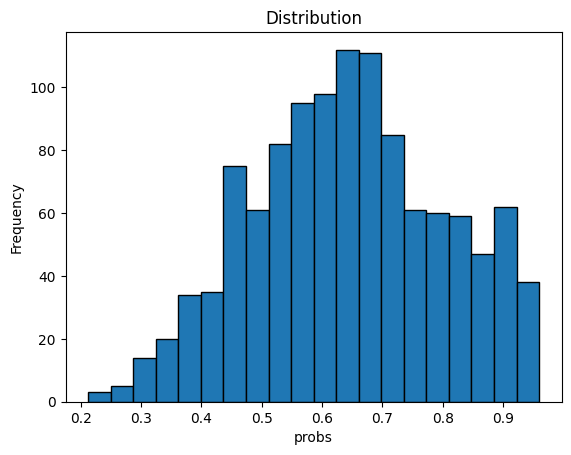

In [62]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [63]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [64]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# nw, months- done

In [12]:
def generate_prompts_list(x, y, words):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_to_num = {
    'January': 'one', 'February': 'two', 'March': 'three', 'April': 'four', 'May': 'five', 'June': 'six',
    'July': 'seven', 'August': 'eight', 'September': 'nine', 'October': 'ten', 'November': 'eleven', 'December': 'twelve'
    }
    months = [month_to_num[i] for i in months]
    prompts_list = []
    for j in range(1024): # this must come first else 1 2 3 overrepresented!
        for i in range(x, y):
            rand_words = random.sample(words, k=5)
            prompt_dict = {
                'S1': months[i],
                'S2': months[i+1],
                'S3': months[i+2],
                'S4': months[i+3],
                'corr': f" {months[i+4]}",
                'incorr': f" {months[i+3]}",
                'text': f"{rand_words[0]} done in {months[i]}. {rand_words[1]} done in {months[i+1]}. {rand_words[2]} done in {months[i+2]}. {rand_words[3]} done in {months[i+3]}. {rand_words[4]} done in",
            }
            prompts_list.append(prompt_dict)
    return prompts_list

# made doesn't get very much; too slow too. try done

# "Claire was born in February. John was born in March. Eve was born in April. Bob was born in”
prompts_list = generate_prompts_list(0, 8, random_single_word_objects)

In [13]:
import copy
month_to_num = {'one': 'January', 'two': 'February', 'three': 'March', 'four': 'April', 'five': 'May', 'six': 'June', 'seven': 'July', 'eight': 'August', 'nine': 'September', 'ten': 'October', 'eleven': 'November', 'twelve': 'December'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    out = copy.deepcopy(data_list)
    for item in out:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
                text = text.replace('dJanuary', 'done')
            item['text'] = text

    return out

# Replace the month names in the data
prompts_list_months = replace_month_names(prompts_list)
prompts_list_months

[{'S1': 'January',
  'S2': 'February',
  'S3': 'March',
  'S4': 'April',
  'corr': ' May',
  'incorr': ' April',
  'text': 'Van done in January. Hat done in February. Ring done in March. Desk done in April. Sun done in'},
 {'S1': 'February',
  'S2': 'March',
  'S3': 'April',
  'S4': 'May',
  'corr': ' June',
  'incorr': ' May',
  'text': 'Ice done in February. Snow done in March. Watch done in April. Sun done in May. Table done in'},
 {'S1': 'March',
  'S2': 'April',
  'S3': 'May',
  'S4': 'June',
  'corr': ' July',
  'incorr': ' June',
  'text': 'Ring done in March. Moon done in April. Queen done in May. Book done in June. Rose done in'},
 {'S1': 'April',
  'S2': 'May',
  'S3': 'June',
  'S4': 'July',
  'corr': ' August',
  'incorr': ' July',
  'text': 'Queen done in April. Oil done in May. Rose done in June. Desk done in July. Car done in'},
 {'S1': 'May',
  'S2': 'June',
  'S3': 'July',
  'S4': 'August',
  'corr': ' September',
  'incorr': ' August',
  'text': 'Light done in May. Ar

In [14]:
prompts_list[5000]

{'S1': 'one',
 'S2': 'two',
 'S3': 'three',
 'S4': 'four',
 'corr': ' five',
 'incorr': ' four',
 'text': 'Orange done in one. Arm done in two. Rose done in three. Watch done in four. Watch done in'}

In [15]:
example_prompt = prompts_list[5000]['text']
example_answer = prompts_list[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Orange', ' done', ' in', ' one', '.', ' Arm', ' done', ' in', ' two', '.', ' Rose', ' done', ' in', ' three', '.', ' Watch', ' done', ' in', ' four', '.', ' Watch', ' done', ' in']
Tokenized answer: [' five']


Performance on answer token:
Rank: 0        Logit: 18.90 Prob: 60.66% Token: | five|

Top 0th token. Logit: 18.90 Prob: 60.66% Token: | five|
Top 1th token. Logit: 17.63 Prob: 16.95% Token: | six|
Top 2th token. Logit: 16.68 Prob:  6.58% Token: | seven|
Top 3th token. Logit: 16.37 Prob:  4.83% Token: | ten|
Top 4th token. Logit: 15.24 Prob:  1.56% Token: | eight|
Top 5th token. Logit: 14.69 Prob:  0.89% Token: | one|
Top 6th token. Logit: 14.46 Prob:  0.71% Token: | fifteen|
Top 7th token. Logit: 14.42 Prob:  0.68% Token: | twenty|
Top 8th token. Logit: 14.35 Prob:  0.64% Token: | four|
Top 9th token. Logit: 14.16 Prob:  0.53% Token: | nine|


Ranks of the answer tokens: [(' five', 0)]

In [16]:
example_prompt = prompts_list_months[5000]['text']
example_answer = prompts_list_months[5000]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Orange', ' done', ' in', ' January', '.', ' Arm', ' done', ' in', ' February', '.', ' Rose', ' done', ' in', ' March', '.', ' Watch', ' done', ' in', ' April', '.', ' Watch', ' done', ' in']
Tokenized answer: [' May']


Performance on answer token:
Rank: 0        Logit: 20.91 Prob: 95.15% Token: | May|

Top 0th token. Logit: 20.91 Prob: 95.15% Token: | May|
Top 1th token. Logit: 16.77 Prob:  1.52% Token: | June|
Top 2th token. Logit: 16.24 Prob:  0.89% Token: | April|
Top 3th token. Logit: 16.00 Prob:  0.70% Token: | July|
Top 4th token. Logit: 15.33 Prob:  0.36% Token: | November|
Top 5th token. Logit: 14.83 Prob:  0.22% Token: | September|
Top 6th token. Logit: 14.77 Prob:  0.21% Token: | October|
Top 7th token. Logit: 14.50 Prob:  0.16% Token: | March|
Top 8th token. Logit: 13.94 Prob:  0.09% Token: | early|
Top 9th token. Logit: 13.80 Prob:  0.08% Token: | late|


Ranks of the answer tokens: [(' May', 0)]

In [17]:
# logit_diffs = []
all_probs = []
all_probs_m = []
good_prompts = []
good_prompts_months = []

eight_group = []
eight_group_months = []
addFlag = False
for prompt_dict, prompt_dict_months in zip(prompts_list, prompts_list_months):
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']
    prompt_months = prompt_dict_months['text']
    answer_months = prompt_dict_months['corr']
    incor_months = prompt_dict_months['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )

    logs_months, probs_months, tok_months, incor_ind_months = get_top_preds_moredata(
        prompt = prompt_months,
        answer = answer_months,
        model = model,
        incor = incor_months
    )

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
        if tok_months[0] == answer_months and probs_months[0] > 2*probs_months[tok_months.index(incor_months)]:
            eight_group.append(prompt_dict)
            eight_group_months.append(prompt_dict_months)
            all_probs.append(probs)
            all_probs_m.append(probs_months)
            # good_prompts.append(prompt_dict)
            # good_prompts_months.append(prompt_dict_months)
            if prompt_dict['S1'] == 'eight':
                if len(eight_group) == 8:
                    good_prompts += eight_group
                    good_prompts_months += eight_group_months
                    print(len(good_prompts))
                eight_group = []
                eight_group_months = []
            if len(good_prompts) == 1024:
            # if len(good_prompts) == 120:
                break

8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024


In [18]:
import pickle

# Saving the dictionary to a file using pickle
with open('nw_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('nw_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_done.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Van done in one. Hat done in two. Ring done in three. Desk done in four. Sun done in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Ice done in two. Snow done in three. Watch done in four. Sun done in five. Table done in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Ring done in three. Moon done in four. Queen done in five. Book done in six. Rose done in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Queen done in four. Oil done in five. Rose done in six. Desk done in seven. Car done in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Light done in five. Arm done in six. Road done in seven. Book done in eight. Ice done in'}, {'S1': 'six', 'S2': 'seven', 'S

In [20]:
import pickle

# Saving the dictionary to a file using pickle
with open('months_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts_months, file)

from google.colab import files

# Download the file to your local machine
files.download('months_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution')

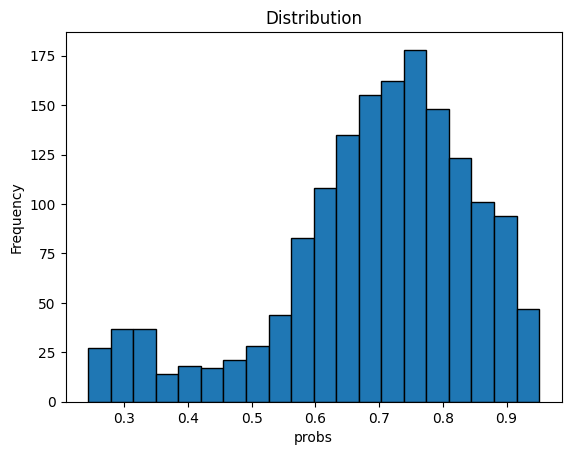

In [21]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

In [22]:
freqs = {}
for pd in good_prompts_months:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'January': 128,
 'February': 128,
 'March': 128,
 'April': 128,
 'May': 128,
 'June': 128,
 'July': 128,
 'August': 128}

In [23]:
freqs = {}
for pd in good_prompts:
    if pd['S1'] not in freqs:
        freqs[pd['S1']] = 1
    else:
        freqs[pd['S1']] += 1
freqs

{'one': 128,
 'two': 128,
 'three': 128,
 'four': 128,
 'five': 128,
 'six': 128,
 'seven': 128,
 'eight': 128}

# digits template dataset, lost

In [65]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_lost.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Oil lost in one. Apple lost in two. Tree lost in three. Snow lost in four. Apple lost in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Rose lost in two. Tree lost in three. Jam lost in four. Mouse lost in five. Wheel lost in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Wallet lost in three. Jam lost in four. Wall lost in five. Watch lost in six. Train lost in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Car lost in four. Camera lost in five. Ring lost in six. Tree lost in seven. Chair lost in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Ice lost in five. Tree lost in six. Desk lost in seven. Desk lost in eight. Pen lost in'}, {'S1': 'six', 'S2': 's

In [66]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Rose lost in 2. Tree lost in 3. Jam lost in 4. Mouse lost in 5. Wheel lost in'},
 {'S1': '3',
  'S2': '4',
  'S3': '5',
  'S4': '6',
  'corr': ' 7',
  'incorr': ' 6',
  'text': 'Wallet lost in 3. Jam lost in 4. Wall lost in 5. Watch lost in 6. Train lost in'},
 {'S1': '4',
  'S2': '5',
  'S3': '6',
  'S4': '7',
  'corr': ' 8',
  'incorr': ' 7',
  'text': 'Car lost in 4. Camera lost in 5. Ring lost in 6. Tree lost in 7. Chair lost in'},
 {'S1': '5',
  'S2': '6',
  'S3': '7',
  'S4': '8',
  'corr': ' 9',
  'incorr': ' 8',
  'text': 'Ice lost in 5. Tree lost in 6. Desk lost in 7. Desk lost in 8. Pen lost in'},
 {'S1': '6',
  'S2': '7',
  'S3': '8',
  'S4': '9',
  'corr': ' 10',
  'incorr': ' 9',
  'text': 'Hill lost in

In [67]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Car', ' lost', ' in', ' 7', '.', ' Night', ' lost', ' in', ' 8', '.', ' Tree', ' lost', ' in', ' 9', '.', ' Desk', ' lost', ' in', ' 10', '.', ' Eye', ' lost', ' in']
Tokenized answer: [' 11']


Performance on answer token:
Rank: 0        Logit: 17.39 Prob: 91.15% Token: | 11|

Top 0th token. Logit: 17.39 Prob: 91.15% Token: | 11|
Top 1th token. Logit: 13.87 Prob:  2.71% Token: |
|
Top 2th token. Logit: 11.76 Prob:  0.33% Token: | 1|
Top 3th token. Logit: 11.43 Prob:  0.24% Token: | 12|
Top 4th token. Logit: 10.90 Prob:  0.14% Token: | 10|
Top 5th token. Logit: 10.79 Prob:  0.12% Token: |

|
Top 6th token. Logit: 10.72 Prob:  0.12% Token: |11|
Top 7th token. Logit: 10.53 Prob:  0.10% Token: |<|endoftext|>|
Top 8th token. Logit: 10.50 Prob:  0.09% Token: |.|
Top 9th token. Logit: 10.44 Prob:  0.09% Token: | -|


Ranks of the answer tokens: [(' 11', 0)]

In [68]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [69]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_lost.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_lost.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_lost.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in'}, {'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Rose lost in 2. Tree lost in 3. Jam lost in 4. Mouse lost in 5. Wheel lost in'}, {'S1': '3', 'S2': '4', 'S3': '5', 'S4': '6', 'corr': ' 7', 'incorr': ' 6', 'text': 'Wallet lost in 3. Jam lost in 4. Wall lost in 5. Watch lost in 6. Train lost in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr': ' 8', 'incorr': ' 7', 'text': 'Car lost in 4. Camera lost in 5. Ring lost in 6. Tree lost in 7. Chair lost in'}, {'S1': '5', 'S2': '6', 'S3': '7', 'S4': '8', 'corr': ' 9', 'incorr': ' 8', 'text': 'Ice lost in 5. Tree lost in 6. Desk lost in 7. Desk lost in 8. Pen lost in'}, {'S1': '6', 'S2': '7', 'S3': '8', 'S4': '9', 'corr': ' 10', 'incorr': ' 9', 'text': 'Hill lost in 6. Clock lost in 7. Nut lost in 8. Van lost in 9. Lake lost in'}, {'S1': '7'

Text(0.5, 1.0, 'Distribution')

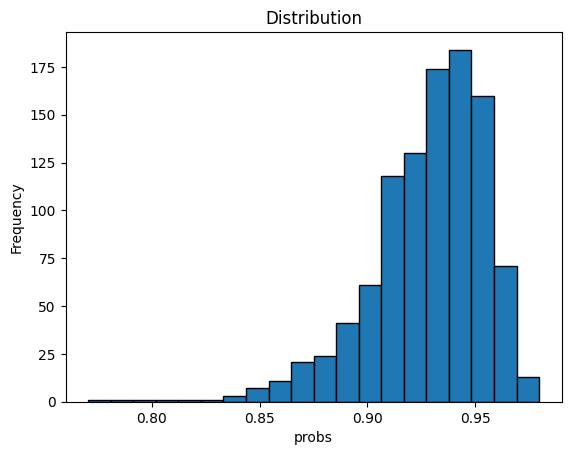

In [71]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, names

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

In [ ]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

In [ ]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

In [ ]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

In [ ]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_names.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_names.pkl')

In [ ]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_names.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

In [ ]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')

# digits template dataset, done

In [25]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'nw_prompts_done.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    prompts_list = pickle.load(file)

# data now contains the contents of your pickle file
print(prompts_list)

[{'S1': 'one', 'S2': 'two', 'S3': 'three', 'S4': 'four', 'corr': ' five', 'incorr': ' four', 'text': 'Van done in one. Hat done in two. Ring done in three. Desk done in four. Sun done in'}, {'S1': 'two', 'S2': 'three', 'S3': 'four', 'S4': 'five', 'corr': ' six', 'incorr': ' five', 'text': 'Ice done in two. Snow done in three. Watch done in four. Sun done in five. Table done in'}, {'S1': 'three', 'S2': 'four', 'S3': 'five', 'S4': 'six', 'corr': ' seven', 'incorr': ' six', 'text': 'Ring done in three. Moon done in four. Queen done in five. Book done in six. Rose done in'}, {'S1': 'four', 'S2': 'five', 'S3': 'six', 'S4': 'seven', 'corr': ' eight', 'incorr': ' seven', 'text': 'Queen done in four. Oil done in five. Rose done in six. Desk done in seven. Car done in'}, {'S1': 'five', 'S2': 'six', 'S3': 'seven', 'S4': 'eight', 'corr': ' nine', 'incorr': ' eight', 'text': 'Light done in five. Arm done in six. Road done in seven. Book done in eight. Ice done in'}, {'S1': 'six', 'S2': 'seven', 'S

In [26]:
month_to_num = {'one': '1', 'two': '2', 'three': '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9', 'ten': '10', 'eleven': '11', 'twelve': '12'}

# Revised function to handle the AttributeError
def replace_month_names(data_list):
    for item in data_list:
        # Replace month names in key-value pairs
        for key in list(item.keys()):  # list() to avoid 'RuntimeError: dictionary changed size during iteration'
            value = item[key]
            if value in month_to_num:
                item[key] = month_to_num[value]
            elif key == 'corr' or key == 'incorr':
                item[key] = " " + month_to_num[value.replace(" ", '')]

        # Replace month names in text fields
        if 'text' in item:
            text = item['text']
            for month_name, month_num in month_to_num.items():
                text = text.replace(month_name, str(month_num))
                text = text.replace('d1', 'done')
            item['text'] = text

    return data_list

# Replace the month names in the data
prompts_list = replace_month_names(prompts_list)
prompts_list

[{'S1': '1',
  'S2': '2',
  'S3': '3',
  'S4': '4',
  'corr': ' 5',
  'incorr': ' 4',
  'text': 'Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in'},
 {'S1': '2',
  'S2': '3',
  'S3': '4',
  'S4': '5',
  'corr': ' 6',
  'incorr': ' 5',
  'text': 'Ice done in 2. Snow done in 3. Watch done in 4. Sun done in 5. Table done in'},
 {'S1': '3',
  'S2': '4',
  'S3': '5',
  'S4': '6',
  'corr': ' 7',
  'incorr': ' 6',
  'text': 'Ring done in 3. Moon done in 4. Queen done in 5. Book done in 6. Rose done in'},
 {'S1': '4',
  'S2': '5',
  'S3': '6',
  'S4': '7',
  'corr': ' 8',
  'incorr': ' 7',
  'text': 'Queen done in 4. Oil done in 5. Rose done in 6. Desk done in 7. Car done in'},
 {'S1': '5',
  'S2': '6',
  'S3': '7',
  'S4': '8',
  'corr': ' 9',
  'incorr': ' 8',
  'text': 'Light done in 5. Arm done in 6. Road done in 7. Book done in 8. Ice done in'},
 {'S1': '6',
  'S2': '7',
  'S3': '8',
  'S4': '9',
  'corr': ' 10',
  'incorr': ' 9',
  'text': 'Ball done in 6. Cow d

In [27]:
example_prompt = prompts_list[510]['text']
example_answer = prompts_list[510]['corr']
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'Watch', ' done', ' in', ' 7', '.', ' Bird', ' done', ' in', ' 8', '.', ' Mouse', ' done', ' in', ' 9', '.', ' Snake', ' done', ' in', ' 10', '.', ' Hat', ' done', ' in']
Tokenized answer: [' 11']


Performance on answer token:
Rank: 0        Logit: 17.74 Prob: 92.32% Token: | 11|

Top 0th token. Logit: 17.74 Prob: 92.32% Token: | 11|
Top 1th token. Logit: 13.42 Prob:  1.23% Token: |
|
Top 2th token. Logit: 13.31 Prob:  1.10% Token: | 12|
Top 3th token. Logit: 12.61 Prob:  0.55% Token: | 1|
Top 4th token. Logit: 11.56 Prob:  0.19% Token: | 13|
Top 5th token. Logit: 11.52 Prob:  0.18% Token: | 10|
Top 6th token. Logit: 11.35 Prob:  0.16% Token: | 21|
Top 7th token. Logit: 11.01 Prob:  0.11% Token: |<|endoftext|>|
Top 8th token. Logit: 10.54 Prob:  0.07% Token: | 6|
Top 9th token. Logit: 10.41 Prob:  0.06% Token: |

|


Ranks of the answer tokens: [(' 11', 0)]

In [28]:
logit_diffs = []
all_probs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['corr']
    incor = prompt_dict['incorr']

    logs, probs, toks, incor_ind = get_top_preds_moredata(
        prompt = prompt,
        answer = answer,
        model = model,
        incor = incor
    )
    if incor_ind == 'cont':
        continue

    # print(f"{prompt} -> {answer}")
    # print(probs[0].item(), probs[1].item())
    if toks[0] == answer and probs[0] > 2*probs[toks.index(incor)]:
    # if toks[0] == answer:
        # print('good')
        all_probs.append(probs)
        print(len(good_prompts))
        # incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        # print(l_diff.item())
        good_prompts.append(prompt_dict)
        if len(good_prompts) == 1024:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
import pickle

# Saving the dictionary to a file using pickle
with open('digits_prompts_done.pkl', 'wb') as file:
    pickle.dump(good_prompts, file)

from google.colab import files

# Download the file to your local machine
files.download('digits_prompts_done.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import pickle

# Replace 'your_file_name.pkl' with the name of your uploaded pickle file
file_name = 'digits_prompts_done.pkl'

# Load the pickle file
with open(file_name, 'rb') as file:
    data = pickle.load(file)

# data now contains the contents of your pickle file
print(data)

[{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'corr': ' 5', 'incorr': ' 4', 'text': 'Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in'}, {'S1': '2', 'S2': '3', 'S3': '4', 'S4': '5', 'corr': ' 6', 'incorr': ' 5', 'text': 'Ice done in 2. Snow done in 3. Watch done in 4. Sun done in 5. Table done in'}, {'S1': '3', 'S2': '4', 'S3': '5', 'S4': '6', 'corr': ' 7', 'incorr': ' 6', 'text': 'Ring done in 3. Moon done in 4. Queen done in 5. Book done in 6. Rose done in'}, {'S1': '4', 'S2': '5', 'S3': '6', 'S4': '7', 'corr': ' 8', 'incorr': ' 7', 'text': 'Queen done in 4. Oil done in 5. Rose done in 6. Desk done in 7. Car done in'}, {'S1': '5', 'S2': '6', 'S3': '7', 'S4': '8', 'corr': ' 9', 'incorr': ' 8', 'text': 'Light done in 5. Arm done in 6. Road done in 7. Book done in 8. Ice done in'}, {'S1': '6', 'S2': '7', 'S3': '8', 'S4': '9', 'corr': ' 10', 'incorr': ' 9', 'text': 'Ball done in 6. Cow done in 7. Book done in 8. Rose done in 9. Key done in'}, {'S1': '7', 'S2': '8

Text(0.5, 1.0, 'Distribution')

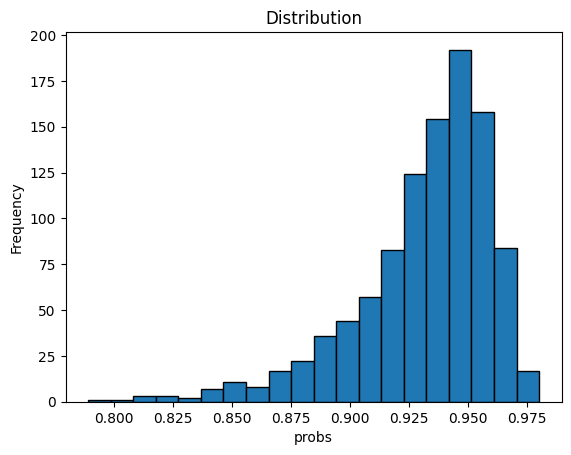

In [31]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
# plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed
plt.hist([probs[0].item() for probs in all_probs], bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('probs')
plt.ylabel('Frequency')
plt.title('Distribution')